In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import posixpath
import wfdb
import pylab 
import pandas as pd

### Show sample record

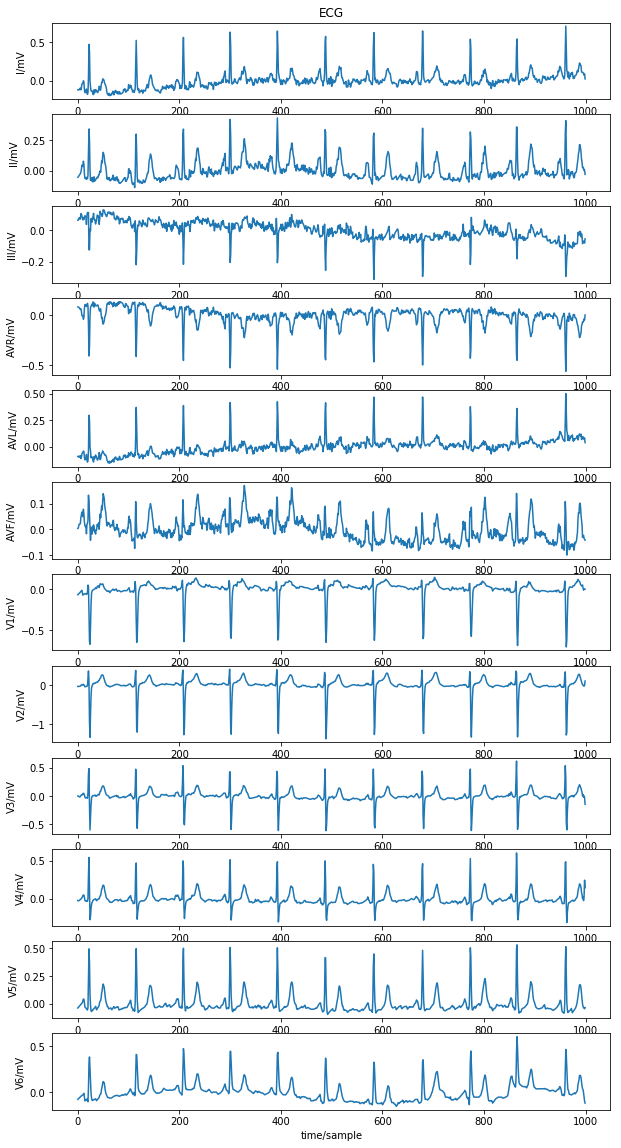

In [2]:
record = wfdb.rdrecord('ptb/records100/00000/00001_lr') 
fig1 = wfdb.plot_wfdb(record=record, title='ECG', figsize=(10,20), return_fig=True)
  
fig1.savefig('test.png', dpi=100)    

### Import Patients Data

In [2]:
df = pd.read_csv("./ptb/ptbxl_database.csv")

In [3]:
df.head(1)

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr


In [4]:
df.columns

Index(['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse',
       'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr'],
      dtype='object')

### Since we don't need all columns, I will take only the below

In [5]:
df_copy = df[['patient_id', 'scp_codes', 'filename_lr', 'filename_hr']]

In [6]:
df_copy.head(1)

,patient_id,scp_codes,filename_lr,filename_hr
0,15709.0,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",records100/00000/00001_lr,records500/00000/00001_hr


In [7]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21837 entries, 0 to 21836
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   patient_id   21837 non-null  float64
 1   scp_codes    21837 non-null  object 
 2   filename_lr  21837 non-null  object 
 3   filename_hr  21837 non-null  object 
dtypes: float64(1), object(3)
memory usage: 682.5+ KB


### Seems we have no null values

### We need to split the scp_code, to take only the subclass

In [8]:
df_copy['sub_class'] = df_copy.scp_codes.str.split("\'",expand=True,)[1]

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
df_copy.head()

,patient_id,scp_codes,filename_lr,filename_hr,sub_class
0,15709.0,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",records100/00000/00001_lr,records500/00000/00001_hr,NORM
1,13243.0,"{'NORM': 80.0, 'SBRAD': 0.0}",records100/00000/00002_lr,records500/00000/00002_hr,NORM
2,20372.0,"{'NORM': 100.0, 'SR': 0.0}",records100/00000/00003_lr,records500/00000/00003_hr,NORM
3,17014.0,"{'NORM': 100.0, 'SR': 0.0}",records100/00000/00004_lr,records500/00000/00004_hr,NORM
4,17448.0,"{'NORM': 100.0, 'SR': 0.0}",records100/00000/00005_lr,records500/00000/00005_hr,NORM


In [10]:
df_copy['sub_class'].value_counts()

NORM       9528
IMI        2329
ASMI       1883
NDT        1477
LVH        1215
LAFB        690
IRBBB       504
CLBBB       500
NST_        463
ILMI        393
AMI         290
PACE        287
ISCAL       275
CRBBB       254
ISC_        180
ALMI        164
IVCD        152
LMI         132
INJAS       112
1AVB        103
ISCAS        92
ISCIN        91
ISCIL        78
WPW          74
LNGQT        68
AFLT         55
LAO/LAE      50
IPLMI        50
AFIB         45
INJAL        37
EL           33
IPMI         30
ILBBB        29
ISCLA        28
PSVT         22
RAO/RAE      20
RVH          17
DIG          16
PVC          14
PMI          14
LPFB         13
ISCAN         9
SEHYP         8
3AVB          3
STACH         3
2AVB          2
INJLA         2
INJIN         2
INJIL         1
Name: sub_class, dtype: int64

### Check the classes available

In [11]:
df_classes = pd.read_csv("./ptb/scp_statements.csv")

In [12]:
df_classes.columns

Index(['Unnamed: 0', 'description', 'diagnostic', 'form', 'rhythm',
       'diagnostic_class', 'diagnostic_subclass', 'Statement Category',
       'SCP-ECG Statement Description', 'AHA code', 'aECG REFID', 'CDISC Code',
       'DICOM Code'],
      dtype='object')

In [13]:
df_classes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     71 non-null     object 
 1   description                    71 non-null     object 
 2   diagnostic                     44 non-null     float64
 3   form                           19 non-null     float64
 4   rhythm                         12 non-null     float64
 5   diagnostic_class               44 non-null     object 
 6   diagnostic_subclass            44 non-null     object 
 7   Statement Category             71 non-null     object 
 8   SCP-ECG Statement Description  71 non-null     object 
 9   AHA code                       37 non-null     float64
 10  aECG REFID                     23 non-null     object 
 11  CDISC Code                     13 non-null     object 
 12  DICOM Code                     13 non-null     objec

In [14]:
df_classes = df_classes[['diagnostic_class', 'diagnostic_subclass', 'description']]

In [15]:
df_classes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   diagnostic_class     44 non-null     object
 1   diagnostic_subclass  44 non-null     object
 2   description          71 non-null     object
dtypes: object(3)
memory usage: 1.8+ KB


In [16]:
df_classes.dropna(inplace=True)

In [17]:
df_classes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 0 to 43
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   diagnostic_class     44 non-null     object
 1   diagnostic_subclass  44 non-null     object
 2   description          44 non-null     object
dtypes: object(3)
memory usage: 1.4+ KB


In [18]:

df_classes.head()

,diagnostic_class,diagnostic_subclass,description
0,STTC,STTC,non-diagnostic T abnormalities
1,STTC,NST_,non-specific ST changes
2,STTC,STTC,digitalis-effect
3,STTC,STTC,long QT-interval
4,NORM,NORM,normal ECG


In [19]:
classes ={}
for index, row in df_classes.iterrows():
    #print(row['diagnostic_class'])
    #print(row['diagnostic_subclass'])
    sub_class = row['diagnostic_subclass']
    cls = row['diagnostic_class']
    
    classes[sub_class] = cls
   
    #break
    
print("available class/subclass")  
print(len(classes))   
print(classes)  


available class/subclass
23
{'STTC': 'STTC', 'NST_': 'STTC', 'NORM': 'NORM', 'IMI': 'MI', 'AMI': 'MI', 'LVH': 'HYP', 'LAFB/LPFB': 'CD', 'ISC_': 'STTC', 'IRBBB': 'CD', '_AVB': 'CD', 'IVCD': 'CD', 'ISCA': 'STTC', 'CRBBB': 'CD', 'CLBBB': 'CD', 'LAO/LAE': 'HYP', 'ISCI': 'STTC', 'LMI': 'MI', 'RVH': 'HYP', 'RAO/RAE': 'HYP', 'WPW': 'CD', 'ILBBB': 'CD', 'SEHYP': 'HYP', 'PMI': 'MI'}


### Map each sub class to its corresponding class

In [20]:
df_copy["cls"] =None
df_copy["cls"]

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0        None
1        None
2        None
3        None
4        None
         ... 
21832    None
21833    None
21834    None
21835    None
21836    None
Name: cls, Length: 21837, dtype: object

In [21]:
for index, row in df_copy.iterrows():
    sub_class = row['sub_class']
    cls = None
    if sub_class in classes.keys():        
        cls = classes[sub_class]
        
    #print(sub_class)
    print(cls)
    df_copy["cls"][index] =cls


NORM
NORM
NORM
NORM
NORM
NORM
NORM
MI
NORM
NORM
NORM
NORM
NORM
NORM
NORM
NORM
None
None
NORM
None
NORM
None
None
NORM
NORM
STTC
NORM
STTC
NORM
HYP
NORM
None
NORM
None
NORM
NORM
NORM
NORM
MI
NORM
None
NORM
NORM
NORM
CD
NORM
NORM
None
CD
MI
NORM
CD
NORM
None
NORM
NORM
NORM
NORM
NORM
NORM
NORM
NORM
None
NORM
CD
NORM
NORM
NORM
NORM
NORM
NORM
NORM
NORM
NORM
NORM
NORM
MI
NORM
NORM
NORM
NORM
NORM
NORM
NORM
NORM
NORM
None
NORM
NORM
NORM
NORM
NORM
NORM
NORM
NORM
HYP
NORM
NORM
NORM
NORM
NORM
None
MI
NORM
NORM
None
NORM
NORM
NORM
NORM
NORM
NORM
NORM
NORM
NORM
None
NORM
NORM
NORM
NORM
NORM
NORM
NORM
NORM
NORM
NORM
None
None
NORM
NORM
None
NORM
None
None
None
NORM
HYP
HYP
MI
HYP
None
MI
None
None
NORM
MI
NORM
None
NORM
NORM
NORM
MI
MI
CD
None
NORM
None
NORM
NORM
STTC
MI
None
NORM
None
NORM
NORM
None
None
CD
STTC
None
CD
HYP
NORM
MI
NORM
None
NORM
NORM
CD
None
None
NORM
None
NORM
None
NORM
CD
None
None
HYP
CD
NORM
NORM
CD
NORM
NORM
NORM
MI
NORM
NORM
NORM
NORM
NORM
NORM
NORM
NORM
NORM
None
MI
MI
NORM

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


None
NORM
None
NORM
HYP
None
None
None
None
STTC
None
NORM
MI
NORM
STTC
None
None
None
NORM
NORM
MI
None
HYP
NORM
MI
MI
None
CD
NORM
NORM
STTC
HYP
NORM
NORM
MI
None
None
None
MI
NORM
NORM
NORM
STTC
MI
None
NORM
NORM
MI
NORM
CD
NORM
STTC
NORM
None
NORM
None
STTC
None
NORM
MI
NORM
None
NORM
NORM
NORM
HYP
NORM
NORM
CD
NORM
NORM
NORM
None
None
None
NORM
NORM
NORM
CD
None
MI
MI
NORM
NORM
MI
NORM
NORM
None
None
HYP
None
NORM
None
None
NORM
NORM
HYP
None
CD
NORM
NORM
CD
STTC
None
NORM
NORM
None
MI
NORM
NORM
NORM
NORM
None
None
None
CD
None
None
NORM
NORM
HYP
NORM
NORM
NORM
NORM
NORM
None
NORM
NORM
NORM
None
None
None
NORM
NORM
NORM
None
NORM
CD
None
NORM
MI
NORM
NORM
NORM
None
NORM
CD
NORM
NORM
NORM
NORM
None
NORM
STTC
NORM
NORM
NORM
None
NORM
CD
MI
None
NORM
NORM
MI
None
NORM
None
CD
None
None
None
None
NORM
NORM
NORM
HYP
NORM
MI
MI
None
CD
None
None
None
None
None
MI
NORM
NORM
CD
CD
None
HYP
NORM
MI
None
None
NORM
MI
NORM
None
None
CD
NORM
NORM
None
None
NORM
CD
MI
NORM
None
MI
NORM
NORM
NO

None
None
HYP
NORM
CD
None
MI
NORM
CD
None
NORM
NORM
NORM
None
NORM
NORM
NORM
NORM
CD
None
MI
NORM
MI
None
None
HYP
NORM
MI
MI
None
NORM
NORM
NORM
NORM
NORM
MI
None
MI
NORM
HYP
NORM
NORM
None
MI
NORM
NORM
NORM
MI
NORM
CD
NORM
CD
CD
NORM
NORM
NORM
NORM
CD
None
NORM
None
None
NORM
CD
MI
NORM
NORM
NORM
NORM
NORM
None
NORM
NORM
NORM
NORM
NORM
NORM
NORM
NORM
None
NORM
NORM
NORM
NORM
NORM
None
NORM
MI
NORM
NORM
CD
None
None
MI
None
None
NORM
NORM
NORM
NORM
NORM
None
NORM
None
None
CD
None
NORM
CD
CD
NORM
NORM
MI
None
None
NORM
NORM
NORM
None
NORM
CD
None
NORM
NORM
NORM
NORM
NORM
None
None
None
STTC
NORM
NORM
None
NORM
NORM
NORM
NORM
NORM
NORM
NORM
None
HYP
HYP
MI
NORM
MI
NORM
NORM
NORM
NORM
MI
NORM
CD
None
CD
MI
None
NORM
None
NORM
None
None
NORM
None
NORM
NORM
None
None
NORM
NORM
None
None
MI
NORM
NORM
None
MI
CD
None
None
None
None
CD
None
CD
MI
None
CD
NORM
NORM
MI
NORM
NORM
NORM
STTC
NORM
None
MI
HYP
HYP
NORM
NORM
NORM
NORM
NORM
None
NORM
NORM
None
NORM
NORM
NORM
None
NORM
HYP
NORM
NORM


MI
MI
CD
MI
NORM
NORM
MI
HYP
NORM
HYP
MI
HYP
NORM
None
CD
None
NORM
MI
NORM
CD
MI
CD
MI
NORM
NORM
None
NORM
None
CD
STTC
CD
MI
None
None
CD
NORM
NORM
NORM
None
NORM
None
CD
CD
None
HYP
NORM
MI
None
NORM
NORM
MI
None
NORM
None
None
NORM
MI
None
None
NORM
None
NORM
NORM
None
NORM
HYP
None
NORM
None
STTC
NORM
STTC
NORM
NORM
NORM
None
None
NORM
NORM
NORM
NORM
NORM
NORM
NORM
HYP
None
NORM
NORM
None
NORM
None
MI
HYP
HYP
MI
None
None
CD
None
None
MI
NORM
HYP
NORM
None
MI
None
NORM
NORM
None
NORM
NORM
MI
CD
HYP
STTC
NORM
NORM
NORM
NORM
None
NORM
None
NORM
NORM
MI
None
None
NORM
NORM
NORM
None
MI
MI
None
None
None
None
NORM
STTC
HYP
HYP
HYP
NORM
NORM
None
None
None
NORM
NORM
NORM
MI
HYP
NORM
NORM
HYP
None
NORM
NORM
NORM
NORM
CD
None
NORM
MI
NORM
NORM
NORM
None
STTC
NORM
None
None
NORM
None
NORM
None
HYP
NORM
None
STTC
NORM
None
NORM
None
MI
NORM
None
None
MI
STTC
None
None
NORM
MI
None
CD
CD
NORM
NORM
STTC
None
HYP
NORM
NORM
NORM
NORM
HYP
None
NORM
None
None
NORM
NORM
None
None
None
NORM
None
N

NORM
MI
None
HYP
NORM
NORM
HYP
HYP
MI
NORM
NORM
CD
NORM
MI
NORM
NORM
NORM
NORM
NORM
NORM
CD
None
None
STTC
HYP
None
NORM
NORM
None
NORM
None
NORM
CD
NORM
HYP
None
MI
CD
NORM
CD
None
NORM
MI
CD
HYP
NORM
NORM
NORM
NORM
MI
MI
None
CD
NORM
MI
NORM
None
CD
NORM
NORM
None
None
None
MI
None
None
NORM
None
CD
CD
None
None
NORM
MI
MI
MI
NORM
None
None
NORM
MI
HYP
NORM
NORM
NORM
None
None
NORM
NORM
NORM
None
None
NORM
NORM
None
None
NORM
CD
NORM
NORM
NORM
NORM
NORM
NORM
NORM
None
None
NORM
NORM
CD
None
NORM
NORM
HYP
HYP
HYP
NORM
NORM
CD
MI
CD
None
NORM
None
NORM
None
MI
NORM
HYP
CD
NORM
NORM
STTC
NORM
NORM
NORM
HYP
CD
NORM
NORM
None
NORM
CD
None
MI
None
NORM
MI
NORM
None
NORM
CD
MI
None
None
None
None
NORM
NORM
None
None
NORM
None
STTC
CD
HYP
None
None
CD
None
NORM
CD
NORM
NORM
NORM
None
None
None
None
NORM
CD
None
NORM
None
None
None
None
CD
None
NORM
None
NORM
CD
CD
None
NORM
NORM
None
NORM
None
STTC
CD
NORM
STTC
NORM
None
HYP
NORM
CD
None
HYP
None
NORM
NORM
NORM
CD
MI
None
CD
NORM
NORM
NORM
N

HYP
NORM
None
NORM
NORM
HYP
NORM
NORM
MI
HYP
None
NORM
NORM
NORM
NORM
None
MI
None
None
None
None
None
MI
None
MI
MI
MI
None
NORM
HYP
NORM
STTC
NORM
None
MI
MI
None
MI
NORM
NORM
None
CD
None
MI
CD
MI
NORM
MI
None
NORM
NORM
None
NORM
NORM
NORM
STTC
NORM
None
NORM
MI
None
HYP
NORM
NORM
MI
None
HYP
NORM
CD
NORM
NORM
NORM
CD
MI
None
NORM
NORM
NORM
NORM
NORM
NORM
MI
MI
None
NORM
None
CD
None
MI
None
NORM
CD
HYP
NORM
NORM
None
None
NORM
MI
NORM
HYP
HYP
None
HYP
MI
None
None
None
CD
HYP
MI
None
CD
MI
MI
MI
None
None
STTC
NORM
None
NORM
NORM
NORM
None
NORM
NORM
MI
MI
NORM
CD
None
MI
NORM
STTC
HYP
MI
NORM
None
NORM
NORM
MI
NORM
NORM
NORM
NORM
NORM
MI
NORM
NORM
STTC
HYP
NORM
None
NORM
NORM
NORM
NORM
NORM
NORM
MI
NORM
MI
HYP
NORM
NORM
None
MI
NORM
HYP
MI
NORM
CD
MI
NORM
None
CD
None
NORM
None
CD
None
HYP
STTC
MI
None
NORM
None
None
None
None
None
STTC
None
HYP
NORM
None
CD
None
NORM
MI
NORM
NORM
None
MI
None
MI
NORM
None
None
NORM
MI
None
None
MI
NORM
NORM
None
NORM
None
NORM
HYP
None
NORM
NORM
N

None
None
MI
MI
MI
None
MI
None
None
NORM
None
MI
None
NORM
STTC
MI
HYP
NORM
NORM
NORM
NORM
NORM
NORM
MI
NORM
HYP
NORM
None
MI
CD
NORM
NORM
NORM
HYP
MI
NORM
NORM
NORM
NORM
MI
MI
NORM
CD
NORM
MI
NORM
None
NORM
None
NORM
HYP
NORM
NORM
HYP
NORM
NORM
HYP
None
HYP
NORM
None
CD
NORM
None
NORM
MI
CD
MI
None
None
NORM
MI
None
NORM
NORM
MI
NORM
None
HYP
NORM
MI
None
CD
NORM
NORM
MI
None
MI
None
NORM
CD
None
None
MI
MI
None
STTC
CD
None
None
None
MI
None
NORM
None
MI
NORM
CD
CD
None
HYP
NORM
NORM
None
None
CD
None
NORM
NORM
NORM
NORM
HYP
None
None
STTC
None
NORM
NORM
None
NORM
None
NORM
None
MI
NORM
None
NORM
None
NORM
NORM
NORM
NORM
None
CD
NORM
None
NORM
MI
NORM
NORM
NORM
MI
None
CD
NORM
CD
None
CD
MI
None
NORM
STTC
CD
MI
NORM
CD
None
NORM
MI
CD
MI
CD
None
MI
NORM
NORM
NORM
NORM
NORM
STTC
None
None
NORM
NORM
NORM
None
NORM
MI
NORM
NORM
NORM
NORM
None
NORM
HYP
None
None
CD
NORM
NORM
NORM
MI
None
NORM
NORM
NORM
NORM
NORM
HYP
NORM
MI
NORM
None
NORM
NORM
None
CD
NORM
HYP
CD
MI
None
None
MI
STTC
HY

NORM
NORM
None
None
NORM
NORM
MI
NORM
NORM
NORM
NORM
None
MI
None
NORM
NORM
CD
MI
MI
None
MI
HYP
NORM
NORM
None
NORM
NORM
NORM
None
NORM
STTC
None
STTC
MI
CD
MI
NORM
NORM
NORM
NORM
None
MI
CD
NORM
None
None
CD
NORM
NORM
None
HYP
NORM
NORM
NORM
NORM
NORM
None
NORM
None
NORM
NORM
MI
NORM
NORM
MI
None
None
MI
NORM
None
None
None
NORM
STTC
NORM
NORM
None
None
MI
NORM
NORM
NORM
None
NORM
None
None
NORM
None
None
None
MI
None
MI
MI
MI
NORM
NORM
None
HYP
None
None
CD
None
NORM
None
None
NORM
None
None
CD
None
None
NORM
None
NORM
NORM
CD
NORM
None
NORM
None
NORM
None
MI
MI
NORM
NORM
None
NORM
NORM
None
None
MI
None
None
None
NORM
NORM
None
None
NORM
NORM
HYP
MI
NORM
NORM
NORM
NORM
None
None
None
None
None
MI
NORM
STTC
CD
CD
None
None
NORM
None
None
NORM
None
NORM
NORM
None
NORM
CD
NORM
HYP
STTC
MI
NORM
None
NORM
None
HYP
NORM
None
HYP
CD
MI
NORM
None
NORM
None
NORM
MI
NORM
None
HYP
HYP
NORM
CD
CD
MI
CD
NORM
None
NORM
NORM
MI
NORM
HYP
None
NORM
NORM
None
HYP
CD
None
NORM
None
CD
NORM
NORM
MI
NO

NORM
MI
NORM
None
None
NORM
None
None
None
None
MI
NORM
NORM
NORM
HYP
NORM
STTC
None
None
MI
MI
HYP
HYP
CD
None
MI
NORM
None
None
MI
None
MI
NORM
MI
None
None
NORM
MI
None
None
MI
NORM
NORM
MI
HYP
MI
NORM
MI
NORM
CD
NORM
NORM
MI
CD
NORM
MI
NORM
None
None
CD
None
NORM
NORM
NORM
None
HYP
CD
MI
MI
MI
HYP
MI
HYP
None
None
MI
NORM
MI
NORM
None
None
None
MI
HYP
CD
NORM
MI
NORM
NORM
None
NORM
CD
MI
None
MI
HYP
MI
None
NORM
None
HYP
MI
None
None
NORM
CD
HYP
NORM
None
NORM
NORM
MI
None
NORM
MI
None
None
None
NORM
MI
NORM
None
NORM
HYP
HYP
MI
None
NORM
HYP
MI
NORM
NORM
NORM
NORM
CD
NORM
None
None
MI
None
HYP
None
NORM
NORM
MI
None
NORM
HYP
None
MI
MI
CD
MI
MI
None
NORM
MI
HYP
HYP
MI
NORM
NORM
NORM
None
None
None
HYP
None
NORM
None
None
MI
CD
None
None
None
None
None
MI
NORM
None
HYP
NORM
NORM
NORM
NORM
NORM
None
None
NORM
MI
NORM
NORM
NORM
None
NORM
None
CD
NORM
NORM
NORM
NORM
None
NORM
CD
MI
NORM
CD
None
NORM
MI
NORM
NORM
NORM
NORM
MI
MI
NORM
MI
NORM
NORM
NORM
NORM
HYP
HYP
MI
NORM
CD
None
CD
MI

CD
NORM
NORM
MI
None
NORM
NORM
NORM
NORM
NORM
None
NORM
MI
MI
HYP
NORM
NORM
HYP
None
MI
None
STTC
None
None
NORM
None
NORM
NORM
NORM
MI
None
NORM
NORM
MI
NORM
NORM
MI
None
NORM
None
CD
NORM
STTC
None
None
NORM
NORM
NORM
NORM
MI
None
NORM
NORM
None
HYP
MI
MI
None
None
NORM
MI
MI
NORM
NORM
NORM
None
MI
NORM
NORM
NORM
None
NORM
NORM
CD
MI
CD
MI
MI
None
None
NORM
NORM
HYP
NORM
NORM
MI
NORM
HYP
STTC
NORM
None
MI
None
STTC
None
HYP
NORM
NORM
NORM
NORM
NORM
NORM
NORM
MI
STTC
NORM
NORM
NORM
None
None
None
None
CD
NORM
NORM
NORM
NORM
NORM
NORM
CD
NORM
HYP
MI
NORM
None
HYP
NORM
HYP
NORM
NORM
CD
None
None
HYP
NORM
MI
CD
HYP
MI
MI
None
NORM
None
NORM
NORM
HYP
NORM
NORM
MI
NORM
NORM
None
NORM
NORM
None
MI
CD
NORM
NORM
None
MI
CD
NORM
None
CD
NORM
NORM
NORM
NORM
NORM
NORM
NORM
None
None
None
NORM
None
CD
NORM
NORM
NORM
NORM
NORM
MI
CD
NORM
NORM
CD
None
HYP
None
HYP
None
NORM
NORM
NORM
NORM
NORM
HYP
MI
NORM
NORM
NORM
NORM
None
NORM
CD
MI
NORM
NORM
CD
None
None
CD
NORM
NORM
None
None
NORM
CD
NORM
None

None
NORM
None
None
None
None
None
None
NORM
None
MI
NORM
MI
None
NORM
NORM
MI
NORM
None
NORM
MI
MI
None
None
None
NORM
None
None
NORM
NORM
None
NORM
MI
HYP
NORM
None
NORM
MI
NORM
None
None
MI
None
NORM
NORM
None
NORM
None
None
CD
None
NORM
NORM
HYP
None
NORM
NORM
MI
NORM
MI
CD
CD
NORM
None
NORM
None
NORM
NORM
MI
None
CD
MI
None
MI
MI
None
NORM
NORM
None
NORM
MI
NORM
NORM
NORM
NORM
MI
NORM
NORM
NORM
None
NORM
NORM
NORM
MI
NORM
MI
None
NORM
None
None
None
CD
MI
MI
NORM
NORM
NORM
MI
NORM
None
MI
NORM
NORM
None
MI
None
None
None
None
NORM
CD
None
NORM
NORM
NORM
NORM
None
MI
None
None
None
CD
None
STTC
NORM
None
None
MI
MI
MI
NORM
NORM
HYP
None
MI
CD
CD
NORM
None
CD
MI
NORM
None
None
NORM
MI
None
NORM
MI
MI
None
None
None
NORM
NORM
NORM
None
NORM
NORM
HYP
None
NORM
NORM
None
None
CD
CD
CD
NORM
NORM
CD
None
MI
None
NORM
NORM
None
None
NORM
NORM
MI
None
HYP
NORM
NORM
STTC
HYP
MI
None
NORM
CD
None
NORM
NORM
None
NORM
None
None
None
NORM
CD
CD
NORM
NORM
NORM
NORM
NORM
CD
MI
NORM
HYP
None
NORM


None
NORM
CD
MI
NORM
NORM
NORM
MI
NORM
MI
MI
MI
NORM
NORM
NORM
None
None
NORM
None
NORM
NORM


In [22]:
df_copy.head()

,patient_id,scp_codes,filename_lr,filename_hr,sub_class,cls
0,15709.0,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",records100/00000/00001_lr,records500/00000/00001_hr,NORM,NORM
1,13243.0,"{'NORM': 80.0, 'SBRAD': 0.0}",records100/00000/00002_lr,records500/00000/00002_hr,NORM,NORM
2,20372.0,"{'NORM': 100.0, 'SR': 0.0}",records100/00000/00003_lr,records500/00000/00003_hr,NORM,NORM
3,17014.0,"{'NORM': 100.0, 'SR': 0.0}",records100/00000/00004_lr,records500/00000/00004_hr,NORM,NORM
4,17448.0,"{'NORM': 100.0, 'SR': 0.0}",records100/00000/00005_lr,records500/00000/00005_hr,NORM,NORM


In [23]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21837 entries, 0 to 21836
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   patient_id   21837 non-null  float64
 1   scp_codes    21837 non-null  object 
 2   filename_lr  21837 non-null  object 
 3   filename_hr  21837 non-null  object 
 4   sub_class    21837 non-null  object 
 5   cls          15759 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1023.7+ KB


In [24]:
df_copy["cls"].value_counts()

NORM    9528
MI      2765
CD      1513
HYP     1310
STTC     643
Name: cls, dtype: int64

In [25]:
df_copy.dropna(inplace=True)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15759 entries, 0 to 21836
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   patient_id   15759 non-null  float64
 1   scp_codes    15759 non-null  object 
 2   filename_lr  15759 non-null  object 
 3   filename_hr  15759 non-null  object 
 4   sub_class    15759 non-null  object 
 5   cls          15759 non-null  object 
dtypes: float64(1), object(5)
memory usage: 861.8+ KB


### split the dataframe 

In [27]:
def save_row(file_path, img_path):
    record = wfdb.rdrecord(file_path) 
    fig1 = wfdb.plot_wfdb(record=record, title='ECG', figsize=(10,20), return_fig=True)
    fig1.savefig(img_path, dpi=100)
    plt.close('all')

In [28]:
def save_imgs(df1):
    for index, row in df1.iterrows():
        #print(row["cls"])
        #print(row["scp_codes"])
        #print(row["filename_lr"])
        print("Patient ID: " , row["patient_id"])
        file_path = "ptb/" + row["filename_lr"]
        img_path= "ptb/classified/" + row["cls"] + "/"+str(row["patient_id"])+".png"
        save_row(file_path, img_path)
        #break

In [29]:
df_STTC = df_copy.query("cls == 'STTC'")
df_HYP = df_copy.query("cls == 'HYP'")
df_MI = df_copy.query("cls == 'MI'")
df_CD = df_copy.query("cls == 'CD'")

In [33]:
df_STTC.head()

,patient_id,scp_codes,filename_lr,filename_hr,sub_class,cls
25,13619.0,"{'NST_': 100.0, 'DIG': 100.0, 'SR': 0.0}",records100/00000/00026_lr,records500/00000/00026_hr,NST_,STTC
27,13619.0,"{'NST_': 100.0, 'DIG': 100.0, 'SR': 0.0}",records100/00000/00028_lr,records500/00000/00028_hr,NST_,STTC
159,13470.0,"{'NST_': 100.0, 'SR': 0.0}",records100/00000/00160_lr,records500/00000/00160_hr,NST_,STTC
169,15691.0,"{'NST_': 100.0, 'PVC': 100.0, 'SR': 0.0}",records100/00000/00170_lr,records500/00000/00170_hr,NST_,STTC
272,340.0,"{'ISC_': 100.0, 'LVH': 100.0, 'VCLVH': 0.0, 'S...",records100/00000/00273_lr,records500/00000/00273_hr,ISC_,STTC


### Below method used to take random sample of the prigional data frame

In [ ]:
start = 0
stop = 4600
for loc in np.arange(4610,17000,10):
    start = stop
    stop = loc
    print("start index: " , start)
    print("stop index:" , stop)
    
    df_part = df_copy.iloc[start:stop,:]
    save_imgs(df_part)
    print("done saving from {} to {}".format(start,stop))
    
    

start index:  4600
stop index: 4610
Patient ID:  20757.0
Patient ID:  19822.0
Patient ID:  11885.0
Patient ID:  8204.0
Patient ID:  15999.0
Patient ID:  20683.0
Patient ID:  10187.0
Patient ID:  12287.0
Patient ID:  11959.0
Patient ID:  16111.0
done saving from 4600 to 4610
start index:  4610
stop index: 4620
Patient ID:  17704.0
Patient ID:  17028.0
Patient ID:  17799.0
Patient ID:  13217.0
Patient ID:  18076.0
Patient ID:  10699.0
Patient ID:  11599.0
Patient ID:  15456.0
Patient ID:  8492.0
Patient ID:  15564.0
done saving from 4610 to 4620
start index:  4620
stop index: 4630
Patient ID:  12609.0
Patient ID:  21067.0
Patient ID:  17313.0
Patient ID:  8492.0
Patient ID:  10505.0
Patient ID:  9602.0
Patient ID:  10820.0
Patient ID:  21530.0
Patient ID:  14798.0
Patient ID:  21143.0
done saving from 4620 to 4630
start index:  4630
stop index: 4640
Patient ID:  13296.0
Patient ID:  11527.0
Patient ID:  11834.0
Patient ID:  20132.0
Patient ID:  21293.0
Patient ID:  9998.0
Patient ID:  17

Patient ID:  15442.0
Patient ID:  18569.0
Patient ID:  20700.0
Patient ID:  17670.0
Patient ID:  4822.0
Patient ID:  1057.0
done saving from 4900 to 4910
start index:  4910
stop index: 4920
Patient ID:  3676.0
Patient ID:  1546.0
Patient ID:  10240.0
Patient ID:  11268.0
Patient ID:  5854.0
Patient ID:  3499.0
Patient ID:  675.0
Patient ID:  4146.0
Patient ID:  8296.0
Patient ID:  17877.0
done saving from 4910 to 4920
start index:  4920
stop index: 4930
Patient ID:  8664.0
Patient ID:  3435.0
Patient ID:  3510.0
Patient ID:  6456.0
Patient ID:  3486.0
Patient ID:  6195.0
Patient ID:  14173.0
Patient ID:  423.0
Patient ID:  6543.0
Patient ID:  16529.0
done saving from 4920 to 4930
start index:  4930
stop index: 4940
Patient ID:  6429.0
Patient ID:  5575.0
Patient ID:  18682.0
Patient ID:  8181.0
Patient ID:  10621.0
Patient ID:  21445.0
Patient ID:  20866.0
Patient ID:  3120.0
Patient ID:  6047.0
Patient ID:  5165.0
done saving from 4930 to 4940
start index:  4940
stop index: 4950
Patie

Patient ID:  5294.0
Patient ID:  8393.0
done saving from 5200 to 5210
start index:  5210
stop index: 5220
Patient ID:  765.0
Patient ID:  5201.0
Patient ID:  11668.0
Patient ID:  19599.0
Patient ID:  2035.0
Patient ID:  12527.0
Patient ID:  16581.0
Patient ID:  16471.0
Patient ID:  13162.0
Patient ID:  10498.0
done saving from 5210 to 5220
start index:  5220
stop index: 5230
Patient ID:  12900.0
Patient ID:  9667.0
Patient ID:  18569.0
Patient ID:  9609.0
Patient ID:  18394.0
Patient ID:  12759.0
Patient ID:  9411.0
Patient ID:  14977.0
Patient ID:  5954.0
Patient ID:  21082.0
done saving from 5220 to 5230
start index:  5230
stop index: 5240
Patient ID:  654.0
Patient ID:  2018.0
Patient ID:  20078.0
Patient ID:  6965.0
Patient ID:  4597.0
Patient ID:  654.0
Patient ID:  13230.0
Patient ID:  11293.0
Patient ID:  1100.0
Patient ID:  6736.0
done saving from 5230 to 5240
start index:  5240
stop index: 5250
Patient ID:  4334.0
Patient ID:  6600.0
Patient ID:  15430.0
Patient ID:  1593.0
Pa

### I will now focus on other classes(than normal, since they are much less
### This is to make samples balanced

In [34]:
save_imgs(df_STTC)

Patient ID:  13619.0
Patient ID:  13619.0
Patient ID:  13470.0
Patient ID:  15691.0
Patient ID:  340.0
Patient ID:  603.0
Patient ID:  603.0
Patient ID:  7592.0
Patient ID:  16023.0
Patient ID:  1631.0
Patient ID:  19497.0
Patient ID:  7616.0
Patient ID:  13474.0
Patient ID:  20068.0
Patient ID:  9027.0
Patient ID:  17206.0
Patient ID:  6099.0
Patient ID:  2555.0
Patient ID:  6097.0
Patient ID:  5559.0
Patient ID:  639.0
Patient ID:  4037.0
Patient ID:  639.0
Patient ID:  639.0
Patient ID:  7224.0
Patient ID:  15493.0
Patient ID:  19607.0
Patient ID:  325.0
Patient ID:  15742.0
Patient ID:  1900.0
Patient ID:  6371.0
Patient ID:  484.0
Patient ID:  1432.0
Patient ID:  1193.0
Patient ID:  7012.0
Patient ID:  566.0
Patient ID:  5889.0
Patient ID:  1368.0
Patient ID:  557.0
Patient ID:  1722.0
Patient ID:  1886.0
Patient ID:  1310.0
Patient ID:  2351.0
Patient ID:  4951.0
Patient ID:  7112.0
Patient ID:  637.0
Patient ID:  2362.0
Patient ID:  13776.0
Patient ID:  21183.0
Patient ID:  984.

Patient ID:  11927.0
Patient ID:  1411.0
Patient ID:  730.0
Patient ID:  5739.0
Patient ID:  4654.0
Patient ID:  2818.0
Patient ID:  4797.0
Patient ID:  13363.0
Patient ID:  9144.0
Patient ID:  9567.0
Patient ID:  20155.0
Patient ID:  15441.0
Patient ID:  3912.0
Patient ID:  5584.0
Patient ID:  387.0
Patient ID:  387.0
Patient ID:  11927.0
Patient ID:  19974.0
Patient ID:  5654.0
Patient ID:  6964.0
Patient ID:  14855.0
Patient ID:  12821.0
Patient ID:  8701.0
Patient ID:  17707.0
Patient ID:  16467.0
Patient ID:  19731.0
Patient ID:  8173.0
Patient ID:  12523.0
Patient ID:  8863.0
Patient ID:  2479.0
Patient ID:  4625.0
Patient ID:  8122.0
Patient ID:  20561.0
Patient ID:  12521.0
Patient ID:  930.0
Patient ID:  12364.0
Patient ID:  3661.0
Patient ID:  5820.0
Patient ID:  5357.0
Patient ID:  7350.0
Patient ID:  6544.0
Patient ID:  1842.0
Patient ID:  5446.0
Patient ID:  4498.0
Patient ID:  2495.0
Patient ID:  21346.0
Patient ID:  20559.0
Patient ID:  798.0
Patient ID:  479.0
Patient I

In [ ]:
save_imgs(df_HYP)

Patient ID:  19053.0
Patient ID:  21698.0
Patient ID:  8727.0
Patient ID:  8727.0
Patient ID:  13451.0
Patient ID:  10676.0
Patient ID:  10630.0
Patient ID:  10783.0
Patient ID:  3192.0
Patient ID:  7614.0
Patient ID:  7852.0
Patient ID:  1110.0
Patient ID:  380.0
Patient ID:  4417.0
Patient ID:  449.0
Patient ID:  449.0
Patient ID:  11809.0
Patient ID:  13110.0
Patient ID:  6683.0
Patient ID:  13237.0
Patient ID:  20065.0
Patient ID:  17649.0
Patient ID:  20767.0
Patient ID:  5606.0
Patient ID:  6069.0
Patient ID:  6056.0
Patient ID:  7565.0
Patient ID:  3879.0
Patient ID:  3671.0
Patient ID:  2132.0
Patient ID:  2396.0
Patient ID:  7485.0
Patient ID:  325.0
Patient ID:  325.0
Patient ID:  7992.0
Patient ID:  834.0
Patient ID:  2841.0
Patient ID:  2764.0
Patient ID:  687.0
Patient ID:  410.0
Patient ID:  410.0
Patient ID:  7061.0
Patient ID:  458.0
Patient ID:  6079.0
Patient ID:  458.0
Patient ID:  1706.0
Patient ID:  557.0
Patient ID:  3943.0
Patient ID:  637.0
Patient ID:  6738.0
P

Patient ID:  15096.0
Patient ID:  14614.0
Patient ID:  14681.0
Patient ID:  15221.0
Patient ID:  13681.0
Patient ID:  10439.0
Patient ID:  20348.0
Patient ID:  8304.0
Patient ID:  8304.0
Patient ID:  9433.0
Patient ID:  20625.0
Patient ID:  8304.0
Patient ID:  9862.0
Patient ID:  9098.0
Patient ID:  8304.0
Patient ID:  8304.0
Patient ID:  9318.0
Patient ID:  8304.0
Patient ID:  18174.0
Patient ID:  12078.0
Patient ID:  8450.0
Patient ID:  19522.0
Patient ID:  15412.0
Patient ID:  9286.0
Patient ID:  12630.0
Patient ID:  18928.0
Patient ID:  9286.0
Patient ID:  20163.0
Patient ID:  453.0
Patient ID:  12137.0
Patient ID:  14282.0
Patient ID:  6229.0
Patient ID:  9286.0
Patient ID:  15067.0
Patient ID:  6562.0
Patient ID:  17183.0
Patient ID:  12605.0
Patient ID:  6111.0
Patient ID:  18347.0
Patient ID:  18370.0
Patient ID:  16707.0
Patient ID:  14317.0
Patient ID:  11974.0
Patient ID:  18347.0
Patient ID:  21336.0
Patient ID:  17216.0
Patient ID:  5524.0
Patient ID:  377.0
Patient ID:  5

Patient ID:  9865.0
Patient ID:  13378.0
Patient ID:  18093.0
Patient ID:  14365.0
Patient ID:  14821.0
Patient ID:  10859.0
Patient ID:  5548.0
Patient ID:  11266.0
Patient ID:  11266.0
Patient ID:  15273.0
Patient ID:  19693.0
Patient ID:  6873.0
Patient ID:  1856.0
Patient ID:  2836.0
Patient ID:  5332.0
Patient ID:  13320.0
Patient ID:  8715.0
Patient ID:  6218.0
Patient ID:  2310.0
Patient ID:  5660.0
Patient ID:  11910.0
Patient ID:  18311.0
Patient ID:  11910.0
Patient ID:  10211.0
Patient ID:  9554.0
Patient ID:  11269.0
Patient ID:  506.0
Patient ID:  21450.0
Patient ID:  21557.0
Patient ID:  7400.0
Patient ID:  21557.0
Patient ID:  6488.0
Patient ID:  15261.0
Patient ID:  15023.0
Patient ID:  10017.0
Patient ID:  10836.0
Patient ID:  17127.0
Patient ID:  2899.0
Patient ID:  7119.0
Patient ID:  3552.0
Patient ID:  21172.0
Patient ID:  4848.0
Patient ID:  10982.0
Patient ID:  17114.0
Patient ID:  3518.0
Patient ID:  3364.0
Patient ID:  479.0
Patient ID:  20819.0
Patient ID:  10

Patient ID:  11275.0
Patient ID:  13619.0
Patient ID:  16961.0
Patient ID:  8555.0
Patient ID:  13722.0
Patient ID:  11121.0
Patient ID:  8159.0
Patient ID:  13447.0
Patient ID:  9796.0
Patient ID:  20254.0
Patient ID:  10634.0
Patient ID:  21114.0
Patient ID:  10746.0
Patient ID:  16062.0
Patient ID:  18690.0
Patient ID:  9601.0
Patient ID:  5750.0
Patient ID:  7662.0
Patient ID:  2282.0
Patient ID:  2261.0
Patient ID:  640.0
Patient ID:  4302.0
Patient ID:  3825.0
Patient ID:  636.0
Patient ID:  3498.0
Patient ID:  19163.0
Patient ID:  15446.0
Patient ID:  7393.0
Patient ID:  1457.0
Patient ID:  4206.0
Patient ID:  1752.0
Patient ID:  5393.0
Patient ID:  3522.0
Patient ID:  9795.0
Patient ID:  14794.0
Patient ID:  19895.0
Patient ID:  943.0
Patient ID:  4160.0
Patient ID:  1168.0
Patient ID:  9982.0
Patient ID:  21231.0
Patient ID:  15942.0
Patient ID:  8144.0
Patient ID:  13772.0
Patient ID:  15734.0
Patient ID:  15180.0
Patient ID:  15279.0
Patient ID:  12015.0
Patient ID:  2536.0


Patient ID:  534.0
Patient ID:  13893.0
Patient ID:  8669.0
Patient ID:  9247.0
Patient ID:  11664.0
Patient ID:  21765.0
Patient ID:  16569.0
Patient ID:  17497.0
Patient ID:  15971.0
Patient ID:  21765.0
Patient ID:  14481.0
Patient ID:  18360.0
Patient ID:  16639.0
Patient ID:  16407.0
Patient ID:  18759.0
Patient ID:  15406.0
Patient ID:  14411.0
Patient ID:  8484.0
Patient ID:  20895.0
Patient ID:  14757.0
Patient ID:  13899.0
Patient ID:  15971.0
Patient ID:  5375.0
Patient ID:  3694.0
Patient ID:  9999.0
Patient ID:  8551.0
Patient ID:  17250.0
Patient ID:  1018.0
Patient ID:  19944.0
Patient ID:  1393.0
Patient ID:  13415.0
Patient ID:  477.0
Patient ID:  9533.0
Patient ID:  1257.0
Patient ID:  16348.0
Patient ID:  6337.0
Patient ID:  18496.0
Patient ID:  8551.0
Patient ID:  10847.0
Patient ID:  609.0
Patient ID:  4836.0
Patient ID:  12180.0
Patient ID:  8551.0
Patient ID:  17299.0
Patient ID:  5598.0
Patient ID:  17619.0
Patient ID:  12625.0
Patient ID:  9709.0
Patient ID:  13

Patient ID:  17353.0
Patient ID:  20727.0
Patient ID:  3719.0
Patient ID:  6117.0
Patient ID:  21144.0
Patient ID:  18902.0
Patient ID:  15585.0
Patient ID:  12267.0
Patient ID:  17270.0
Patient ID:  19498.0
Patient ID:  8152.0
Patient ID:  13777.0
Patient ID:  13970.0
Patient ID:  9740.0
Patient ID:  18203.0
Patient ID:  12734.0
Patient ID:  1840.0
Patient ID:  20744.0
Patient ID:  6055.0
Patient ID:  7102.0
Patient ID:  7651.0
Patient ID:  3862.0
Patient ID:  6172.0
Patient ID:  446.0
Patient ID:  16880.0
Patient ID:  446.0
Patient ID:  9740.0
Patient ID:  2312.0
Patient ID:  659.0
Patient ID:  7358.0
Patient ID:  7713.0
Patient ID:  1064.0
Patient ID:  719.0
Patient ID:  21170.0
Patient ID:  14085.0
Patient ID:  9959.0
Patient ID:  19410.0
Patient ID:  13735.0
Patient ID:  12939.0
Patient ID:  16194.0
Patient ID:  21683.0
Patient ID:  20293.0
Patient ID:  13741.0
Patient ID:  15736.0
Patient ID:  19621.0
Patient ID:  21445.0
Patient ID:  7836.0
Patient ID:  3170.0
Patient ID:  13557

KeyboardInterrupt: 

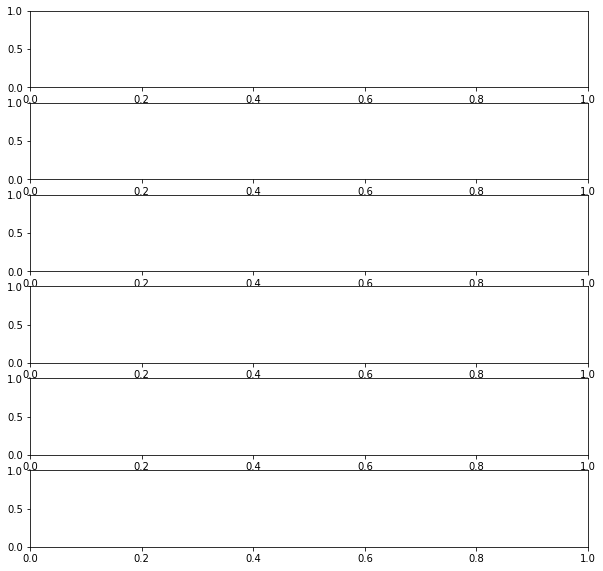

In [30]:
save_imgs(df_MI)

In [ ]:
save_imgs(df_CD)

Patient ID:  18794.0
Patient ID:  13958.0
Patient ID:  18153.0
Patient ID:  19170.0
Patient ID:  13617.0
Patient ID:  13688.0
Patient ID:  20766.0
Patient ID:  15592.0
Patient ID:  13483.0
Patient ID:  8340.0
Patient ID:  14472.0
Patient ID:  4867.0
Patient ID:  565.0
Patient ID:  437.0
Patient ID:  6410.0
Patient ID:  7479.0
Patient ID:  565.0
Patient ID:  4257.0
Patient ID:  5026.0
Patient ID:  4902.0
Patient ID:  16942.0
Patient ID:  7705.0
Patient ID:  16695.0
Patient ID:  12006.0
Patient ID:  12171.0
Patient ID:  2936.0
Patient ID:  15114.0
Patient ID:  583.0
Patient ID:  6417.0
Patient ID:  3378.0
Patient ID:  392.0
Patient ID:  9050.0
Patient ID:  1377.0
Patient ID:  3445.0
Patient ID:  3805.0
Patient ID:  1508.0
Patient ID:  6903.0
Patient ID:  565.0
Patient ID:  17445.0
Patient ID:  565.0
Patient ID:  14509.0
Patient ID:  10756.0
Patient ID:  21542.0
Patient ID:  21542.0
Patient ID:  16040.0
Patient ID:  6708.0
Patient ID:  6730.0
Patient ID:  5322.0
Patient ID:  7639.0
Patien

Patient ID:  8986.0
Patient ID:  16067.0
Patient ID:  8035.0
Patient ID:  14896.0
Patient ID:  19319.0
Patient ID:  7802.0
Patient ID:  8006.0
Patient ID:  10107.0
Patient ID:  10107.0
Patient ID:  10107.0
Patient ID:  10107.0
Patient ID:  10107.0
Patient ID:  10107.0
Patient ID:  19551.0
Patient ID:  11345.0
Patient ID:  15860.0
Patient ID:  10107.0
Patient ID:  17819.0
Patient ID:  9369.0
Patient ID:  10107.0
Patient ID:  12372.0
Patient ID:  8550.0
Patient ID:  19426.0
Patient ID:  21483.0
Patient ID:  4047.0
Patient ID:  15763.0
Patient ID:  12588.0
Patient ID:  13955.0
Patient ID:  11764.0
Patient ID:  6744.0
Patient ID:  1130.0
Patient ID:  8393.0
Patient ID:  5201.0
Patient ID:  2035.0
Patient ID:  14977.0
Patient ID:  20078.0
Patient ID:  4597.0
Patient ID:  6872.0
Patient ID:  12588.0
Patient ID:  15852.0
Patient ID:  20078.0
Patient ID:  12567.0
Patient ID:  19963.0
Patient ID:  15715.0
Patient ID:  17677.0
Patient ID:  9083.0
Patient ID:  15873.0
Patient ID:  16420.0
Patient

Patient ID:  8735.0
Patient ID:  577.0
Patient ID:  472.0
Patient ID:  11104.0
Patient ID:  18096.0
Patient ID:  17243.0
Patient ID:  6280.0
Patient ID:  472.0
Patient ID:  7069.0
Patient ID:  1286.0
Patient ID:  17926.0
Patient ID:  7874.0
Patient ID:  7368.0
Patient ID:  7299.0
Patient ID:  19414.0
Patient ID:  1873.0
Patient ID:  5952.0
Patient ID:  20209.0
Patient ID:  20619.0
Patient ID:  1337.0
Patient ID:  16889.0
Patient ID:  11981.0
Patient ID:  11981.0
Patient ID:  4015.0
Patient ID:  6930.0
Patient ID:  8987.0
Patient ID:  4774.0
Patient ID:  19678.0
Patient ID:  9737.0
Patient ID:  13421.0
Patient ID:  18160.0
Patient ID:  14685.0
Patient ID:  17385.0
Patient ID:  21712.0
Patient ID:  2741.0
Patient ID:  11676.0
Patient ID:  10697.0
Patient ID:  12693.0
Patient ID:  12591.0
Patient ID:  6642.0
Patient ID:  13075.0
Patient ID:  787.0
Patient ID:  20764.0
Patient ID:  9370.0
Patient ID:  16591.0
Patient ID:  9737.0
Patient ID:  21126.0
Patient ID:  9969.0
Patient ID:  19820.0

Patient ID:  16391.0
Patient ID:  2635.0
Patient ID:  3653.0
Patient ID:  500.0
Patient ID:  4679.0
Patient ID:  7059.0
Patient ID:  19569.0
Patient ID:  10996.0
Patient ID:  1816.0
Patient ID:  11264.0
Patient ID:  326.0
Patient ID:  13522.0
Patient ID:  15884.0
Patient ID:  7904.0
Patient ID:  6128.0
Patient ID:  5193.0
Patient ID:  3436.0
Patient ID:  2900.0
Patient ID:  19009.0
Patient ID:  5283.0
Patient ID:  500.0
Patient ID:  7005.0
Patient ID:  7306.0
Patient ID:  4493.0
Patient ID:  18725.0
Patient ID:  4604.0
Patient ID:  21786.0
Patient ID:  11088.0
Patient ID:  9143.0
Patient ID:  8329.0
Patient ID:  21182.0
Patient ID:  19857.0
Patient ID:  11133.0
Patient ID:  14969.0
Patient ID:  19787.0
Patient ID:  9407.0
Patient ID:  18509.0
Patient ID:  8513.0
Patient ID:  9400.0
Patient ID:  15793.0
Patient ID:  9407.0
Patient ID:  16527.0
Patient ID:  12713.0
Patient ID:  3031.0
Patient ID:  11750.0
Patient ID:  21792.0
Patient ID:  4327.0
Patient ID:  3733.0
Patient ID:  1003.0
Pa